## **Flow-Chart**

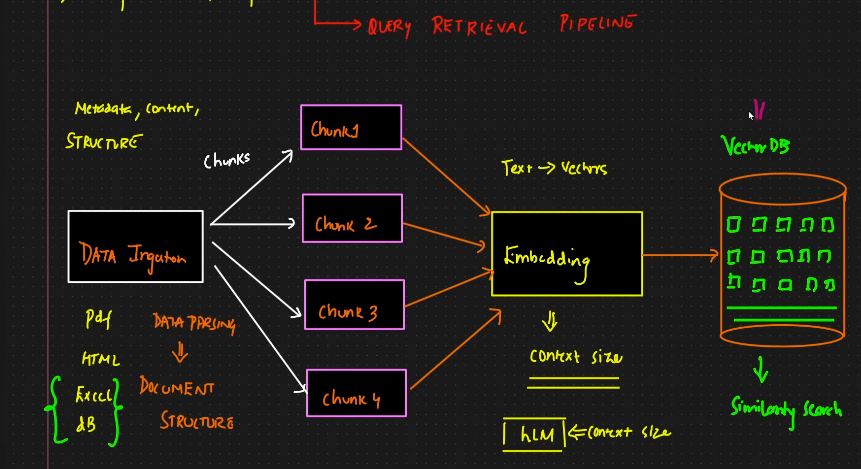

## Data Ingestion

In [ ]:
# Document Data-Structure

from langchain_core.documents import Document

In [ ]:
doc = Document(
    page_content="This is the main text content I 'm using to create RAG.",
    metadata = {
        "source" : "example.txt",
        "pages" : 1,
        "author" : "Soubhik Sinha",
        "date_created" : "2025-09-28"
    }
)

# The above metadata can help when applied similarity search (as filters)

In [ ]:
doc

In [ ]:
# Creating a (.txt) file folder

import os
os.makedirs("../data/text_files", exist_ok = True)

In [ ]:
sample_texts = {
    "../data/text_files/python_intro.txt" : """Python Introduction

Python is a high-level, interpreted programming language known for its simplicity and readability. Created by Guido van Rossum in 1991, Python has grown into one of the most widely used languages in software development, data science, artificial intelligence, web development, and automation. Its syntax is easy to learn, making it beginner-friendly, while its vast ecosystem of libraries and frameworks makes it powerful for professionals.

Python supports multiple programming paradigms, including object-oriented, procedural, and functional programming. Popular libraries such as NumPy, Pandas, TensorFlow, and Flask extend its capabilities across diverse domains like data analysis, machine learning, and web applications. With an active community and strong industry adoption, Python continues to be a go-to language for solving real-world problems.
""",
"../data/text_files/ML_intro.txt" : """Machine Learning Introduction

Machine Learning (ML) is a branch of Artificial Intelligence that enables systems to automatically learn from data and improve performance without being explicitly programmed. Instead of following fixed rules, ML algorithms identify patterns, build models, and make predictions or decisions based on input data.

It is widely used in areas such as image and speech recognition, natural language processing, recommendation systems, healthcare, and finance. Common approaches include supervised learning, unsupervised learning, and reinforcement learning. With the growth of big data and advanced computing power, ML has become a core technology driving innovations in AI and automation.
"""
}

for filepath, content in sample_texts.items():
    with open(filepath, 'w', encoding = "utf-8") as f:
        f.write(content)
    
print("✅ Sample text file(s) created !")

In [ ]:
# Reading the text files content using TextLoader

from langchain.document_loaders import TextLoader
from langchain_community.document_loaders import TextLoader

loader = TextLoader("../data/text_files/python_intro.txt", encoding="utf-8")
document = loader.load()
print(document) # Here the content of the text file is returned as a "Document Structure"

In [ ]:
# Directory Loader
from langchain_community.document_loaders import DirectoryLoader

# Loading all the text files from the directory
dir_loader = DirectoryLoader(
    "../data/text_files",
    glob = "**/*.txt", # Pattern to match files
    loader_cls = TextLoader, # Loader class to use
    loader_kwargs = {'encoding' : 'utf-8'}, # File loading encoder
    show_progress = True
)

documents = dir_loader.load()

In [ ]:
documents

In [ ]:
# If we also need to read through the PDF files and the text files

# Loading all the PDF files from the directory
from langchain_community.document_loaders import PyPDFLoader, PyMuPDFLoader

dir_loader = DirectoryLoader(
    "../data/pdf_files",
    glob = "**/*.pdf", # Pattern to match files
    loader_cls = PyMuPDFLoader, # Loader class to use
    # loader_kwargs = {'encoding' : 'utf-8'}, # File loading encoder
    show_progress = True
)

pdf_documents = dir_loader.load()
pdf_documents

In [ ]:
type(pdf_documents[0])

<br>
<br>

## Chunking, Embedding and VectorStoreDB

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pathlib import Path

In [ ]:
# Reading all the pdf's inside the directory
def process_all_pdfs(pdf_directory):
    """Process all PDF files in a directory"""
    all_documents = []
    pdf_dir = Path(pdf_directory)
    
    # Finding all PDF files recursively
    pdf_files = list(pdf_dir.glob("**/*.pdf"))
    
    print(f"Found {len(pdf_files)} PDF files to process")
    
    for pdf_file in pdf_files:
        print(f"\nProcessing: {pdf_file.name}")
        try:
            loader = PyPDFLoader(str(pdf_file))
            documents = loader.load()
            
            # Adding source information to metadata
            for doc in documents:
                doc.metadata['source_file'] = pdf_file.name
                doc.metadata['file_type'] = 'pdf'
            
            all_documents.extend(documents)
            print(f"  ✓ Loaded {len(documents)} pages")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    print(f"\nTotal documents loaded: {len(all_documents)}")
    return all_documents

# Process all PDFs in the data directory
all_pdf_documents = process_all_pdfs("../data")

In [ ]:
all_pdf_documents

In [ ]:
# Text splitting get into chunks

def split_documents(documents,chunk_size=1000,chunk_overlap=200):
    """Split documents into smaller chunks for better RAG performance"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(split_docs)} chunks")
    
    # Showing example of a chunk
    if split_docs:
        print(f"\nExample chunk:")
        print(f"Content: {split_docs[0].page_content[:200]}...")
        print(f"Metadata: {split_docs[0].metadata}")
    
    return split_docs

In [ ]:
chunks=split_documents(all_pdf_documents)
chunks

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import uuid
from typing import List, Dict, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Embedding

class EmbeddingManager:
    """Handles document embedding generation using SentenceTransformer"""

    def __init__(self, model_name: str = "all-MiniLM-L6-v2"): # 384 dimensions
        """Initialize the embedding manager
        
        Args:
            model_name: HuggingFace model name for Sentence Embeddings
        """
        self.model_name = model_name
        self.model = None
        self._load_model()
    
    def _load_model(self): # Adding extra under-score in the beginning of the function name : Protected Function
        """Load teh SentenceTransformer model"""

        try:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            print(f"Model loaded successfully! Embedding Dimension : {self.model.get_sentence_embedding_dimension()}")
        except Exception as e:
            print(f"Error loading model {self.model_name}: {e}")
            raise
    
    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """
        Generate embeddings for a list of texts

        Args:
            texts: List of text strings to embed
        
        Returns:
            numpy array of embeddings with shape (len(texts), embedding_dim)
        """
        if not self.model:
            raise ValueError("Model not loaded")
    
        print(f"Generating embeddings for {len(texts)} texts ...")
        embeddings = self.model.encode(texts, show_progress_bar = True)
        print(f"Generated embeddings with shape: {embeddings.shape}")
        return embeddings

# Initializing teh embedding manager
embedding_manager = EmbeddingManager()
embedding_manager

In [ ]:
# VectorStore Class

class VectorStore:
    """Manages document embeddings in a ChromaDB vector store"""

    def __init__(self, collection_name: str = "pdf_documents", persist_directory: str = "../data/vector_store"):
        """
        Initialize the vector store

        Args:
            collection_name: Name of the Chroma DB collection
            persist_directory: Directory to persist the vector store
        """
        self.collection_name = collection_name
        self.persist_directory = persist_directory
        self.client = None
        self.collection = None
        self._initialize_store() # Protected Function
    
    def _initialize_store(self):
        """Initialize ChromaDB client and collection"""

        try:
            # Creating persistent ChromaDB client
            os.makedirs(self.persist_directory, exist_ok=True)
            self.client = chromadb.PersistentClient(path = self.persist_directory)

            # Get/Create Collection
            self.collection = self.client.get_or_create_collection(
                name = self.collection_name,
                metadata={"description" : "PDF document embeddings for RAG"}
            )

            print(f"Vector Store Initialized! Collection: {self.collection_name}")
            print(f"Existing documents in collection: {self.collection.count()}")
        except Exception as e:
            print(f"Error initializing vector store : {e}")
            raise
    
    def add_documents(self, documents: List[Any], embeddings: np.ndarray):
        """
        Add documents and their embeddings to the Vector Store
        
        Args:
            documents: List of Langchain Documents
            embeddings: Corresponding embeddings of the documents
        """
        if len(documents) != len(embeddings):
            raise ValueError("Numebr of documents must match the number of embeddings")
        
        print(f"Adding {len(documents)} documents to vector store...")

        # Preparing data for ChromaDB
        ids = []
        metadatas = []
        documents_text = []
        embeddings_list = []

        for i, (doc, embedding) in enumerate(zip(documents, embeddings)):
            # Generating Unique IDs
            doc_id = f"doc_{uuid.uuid4().hex[:8]}_{i}"
            ids.append(doc_id)

            # Preparing metadata
            metadata = dict(doc.metadata)
            metadata['doc_index'] = i
            metadata['content_length'] = len(doc.page_content)
            metadatas.append(metadata)

            # Document content
            documents_text.append(doc.page_content)

            # Embedding
            embeddings_list.append(embedding.tolist())
        
        # Adding the documents to teh Vector Store
        try:
            self.collection.add(
                ids = ids,
                embeddings = embeddings_list,
                metadatas=metadatas,
                documents = documents_text
            )
            print(f"Successfully Added {len(documents)} documents to the Vector Store!")
            print(f"Total documents in collection: {self.collection.count()}")
        except Exception as e:
            print(f"Error adding documents to the Vector Store: {e}")
            raise

# Initializiing Vector Store
vector_store = VectorStore()
vector_store

In [ ]:
chunks

In [ ]:
# Converting Text to Embeddings 
texts=[doc.page_content for doc in chunks]
texts

In [ ]:
# Generating the Embeddings
embeddings=embedding_manager.generate_embeddings(texts)

In [ ]:
# Storing in the vector database
vector_store.add_documents(chunks,embeddings)

<br>
<br>

## **Retriever Pipeline From VectorStoreDB**

In [ ]:
class RAGRetriever:
    """Handles query-based retrieval from the vector store"""
    
    def __init__(self, vector_store: VectorStore, embedding_manager: EmbeddingManager):
        """
        Initialize the retriever
        
        Args:
            vector_store: Vector store containing document embeddings
            embedding_manager: Manager for generating query embeddings
        """
        self.vector_store = vector_store
        self.embedding_manager = embedding_manager

    def retrieve(self, query: str, top_k: int = 5, score_threshold: float = 0.0) -> List[Dict[str, Any]]:
        """
        Retrieve relevant documents for a query
        
        Args:
            query: The search query
            top_k: Number of top (k) results to return
            score_threshold: Minimum similarity score threshold
            
        Returns:
            List of dictionaries containing retrieved documents and metadata
        """
        print(f"Retrieving documents for query: '{query}'")
        print(f"Top K: {top_k}, Score threshold: {score_threshold}")
        
        # Generating query embedding
        query_embedding = self.embedding_manager.generate_embeddings([query])[0]
        
        # Searching in vector store
        try:
            results = self.vector_store.collection.query(
                query_embeddings=[query_embedding.tolist()],
                n_results=top_k
            )
            
            # Processing results
            retrieved_docs = []
            
            if results['documents'] and results['documents'][0]:
                documents = results['documents'][0]
                metadatas = results['metadatas'][0]
                distances = results['distances'][0]
                ids = results['ids'][0]
                
                for i, (doc_id, document, metadata, distance) in enumerate(zip(ids, documents, metadatas, distances)):
                    # Converting distance to similarity score (ChromaDB uses cosine distance)
                    similarity_score = 1 - distance
                    
                    if similarity_score >= score_threshold:
                        retrieved_docs.append({
                            'id': doc_id,
                            'content': document,
                            'metadata': metadata,
                            'similarity_score': similarity_score,
                            'distance': distance,
                            'rank': i + 1
                        })
                
                print(f"Retrieved {len(retrieved_docs)} documents (after filtering)")
            else:
                print("No documents found")
            
            return retrieved_docs
            
        except Exception as e:
            print(f"Error during retrieval: {e}")
            return []

rag_retriever=RAGRetriever(vector_store,embedding_manager)

In [ ]:
rag_retriever

In [ ]:
rag_retriever.retrieve("Attention is all you need")

<br>
<br>

## **RAG Pipeline- VectorDB To LLM Output Generation**

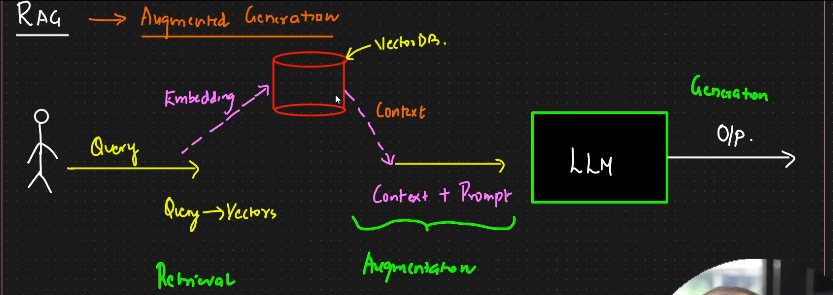

In [ ]:
from dotenv import load_dotenv
load_dotenv()

# print(os.getenv("GROQ_API_KEY"))

In [ ]:
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage

In [ ]:
class GroqLLM:
    def __init__(self, model_name: str = "llama-3.1-8b-instant", api_key: str =None):
        """
        Initialize Groq LLM
        
        Args:
            model_name: Groq model name (qwen2-72b-instruct, llama3-70b-8192, etc.)
            api_key: Groq API key (or set GROQ_API_KEY environment variable)
        """
        self.model_name = model_name
        self.api_key = api_key or os.environ.get("GROQ_API_KEY")
        
        if not self.api_key:
            raise ValueError("Groq API key is required. Set GROQ_API_KEY environment variable or pass api_key parameter.")
        
        self.llm = ChatGroq(
            groq_api_key=self.api_key,
            model_name=self.model_name,
            temperature=0.1,
            max_tokens=1024
        )
        
        print(f"Initialized Groq LLM with model: {self.model_name}")

    def generate_response(self, query: str, context: str, max_length: int = 500) -> str:
        """
        Generate response using retrieved context
        
        Args:
            query: User question
            context: Retrieved document context
            max_length: Maximum response length
            
        Returns:
            Generated response string
        """
        
        # Create prompt template
        prompt_template = PromptTemplate(
            input_variables=["context", "question"],
            template="""You are a helpful AI assistant. Use the following context to answer the question accurately and concisely.

Context:
{context}

Question: {question}

Answer: Provide a clear and informative answer based on the context above. If the context doesn't contain enough information to answer the question, say so."""
        )
        
        # Formatting the prompt
        formatted_prompt = prompt_template.format(context=context, question=query)
        
        try:
            # Generating response
            messages = [HumanMessage(content=formatted_prompt)]
            response = self.llm.invoke(messages)
            return response.content
            
        except Exception as e:
            return f"Error generating response: {str(e)}"
        
    def generate_response_simple(self, query: str, context: str) -> str:
        """
        Simple response generation without complex prompting
        
        Args:
            query: User question
            context: Retrieved context
            
        Returns:
            Generated response
        """
        simple_prompt = f"""Based on this context: {context}

Question: {query}

Answer:"""
        
        try:
            messages = [HumanMessage(content=simple_prompt)]
            response = self.llm.invoke(messages)
            return response.content
        except Exception as e:
            return f"Error: {str(e)}"

In [ ]:
# Initializing Groq LLM
try:
    groq_llm = GroqLLM(api_key=os.getenv("GROQ_API_KEY"))
    print("Groq LLM initialized successfully!")
except ValueError as e:
    print(f"Warning: {e}")
    print("Please set your GROQ_API_KEY environment variable to use the LLM.")
    groq_llm = None

In [ ]:
# Getting the context from the retriever and passing it to the LLM

rag_retriever.retrieve("Attention")

In [ ]:
# Initializing Groq API Key and LLM

groq_api_key = os.getenv("GROQ_API_KEY")

In [ ]:
llm = ChatGroq(groq_api_key = groq_api_key, model_name = "llama-3.1-8b-instant")

In [ ]:
# Simple RAG Function

def rag_simple(query, retriever, llm, top_k = 3):
    results = retriever.retrieve(query, top_k = top_k)
    context = "/n/n".join([doc['content'] for doc in results]) if results else ""
    if not context:
        return "No relevant context found to answer teh question !"

    # Generating the answer using GROQ LLM
    prompt = """Use the follow context to answer the question(s) concisely.
        Context:
        {context}
        Question: {query}
        Answer:
    """

    response= llm.invoke([prompt.format(context = context, query = query)])
    return response.content

In [ ]:
answer = rag_simple("Attention", rag_retriever, llm)
print(answer)

<br>
<br>

## **Enhancing RAG Pipeline Features**

In [44]:
def rag_advanced(query, retriever, llm, top_k=5, min_score=0.2, return_context=False):
    """
    RAG pipeline with extra features:
    - Returns answer, sources, confidence score, and optionally full context.
    """
    results = retriever.retrieve(query, top_k=top_k, score_threshold=min_score)
    if not results:
        return {'answer': 'No relevant context found.', 'sources': [], 'confidence': 0.0, 'context': ''}
    
    # Preparing context and sources
    context = "\n\n".join([doc['content'] for doc in results])
    sources = [{
        'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
        'page': doc['metadata'].get('page', 'unknown'),
        'score': doc['similarity_score'],
        'preview': doc['content'][:300] + '...'
    } for doc in results]
    confidence = max([doc['similarity_score'] for doc in results])
    
    # Generating answer
    prompt = f"""Use the following context to answer the question concisely.\nContext:\n{context}\n\nQuestion: {query}\n\nAnswer:"""
    response = llm.invoke([prompt.format(context=context, query=query)])
    
    output = {
        'answer': response.content,
        'sources': sources,
        'confidence': confidence
    }
    if return_context:
        output['context'] = context
    return output

# Example Use Case:
result = rag_advanced("Attention and YOLO", rag_retriever, llm, top_k=3, min_score=0.1, return_context=True)
print("Answer:", result['answer'])
print("Sources:", result['sources'])
print("Confidence:", result['confidence'])
print("Context Preview:", result['context'][:300])

Retrieving documents for query: 'Attention and YOLO'
Top K: 3, Score threshold: 0.1
Generating embeddings for 1 texts ...


Batches: 100%|██████████| 1/1 [00:00<00:00, 32.91it/s]

Generated embeddings with shape: (1, 384)
Retrieved 3 documents (after filtering)


Answer: While the provided context does not directly discuss attention and YOLO, we can infer that YOLO implicitly encodes contextual information about classes as well as their appearance by seeing the entire image during training and test time. This can be seen as a form of contextual attention, where the model focuses on the entire image to make predictions, rather than relying on specific regions or proposals. However, a more explicit form of attention mechanism is not mentioned in the context.
Sources: [{'source': 'YOLO.pdf', 'page': 1, 'score': 0.23792052268981934, 'preview': 'making predictions. Unlike sliding window and region\nproposal-based techniques, YOLO sees the entire image\nduring training and test time so it implicitly encodes contex-\ntual information about classes as well as their appearance.\nFast R-CNN, a top detection method [14], mistakes back-\nground patches...'}, {'source': 'YOLO.pdf', 'page': 1, 'score': 0.23792052268981934, 'preview': 'making predictions. Unl

In [ ]:
"""
Advanced RAG Pipeline: Streaming, Citations, History, Summarization
"""

from typing import List, Dict, Any
import time

class AdvancedRAGPipeline:
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm
        self.history = []  # Storing query history

    def query(self, question: str, top_k: int = 5, min_score: float = 0.2, stream: bool = False, summarize: bool = False) -> Dict[str, Any]:
        # Retrieving relevant documents
        results = self.retriever.retrieve(question, top_k=top_k, score_threshold=min_score)
        if not results:
            answer = "No relevant context found."
            sources = []
            context = ""
        else:
            context = "\n\n".join([doc['content'] for doc in results])
            sources = [{
                'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
                'page': doc['metadata'].get('page', 'unknown'),
                'score': doc['similarity_score'],
                'preview': doc['content'][:120] + '...'
            } for doc in results]
            # Streaming answer simulation
            prompt = f"""Use the following context to answer the question concisely.\nContext:\n{context}\n\nQuestion: {question}\n\nAnswer:"""
            if stream:
                print("Streaming answer:")
                for i in range(0, len(prompt), 80):
                    print(prompt[i:i+80], end='', flush=True)
                    time.sleep(0.05)
                print()
            response = self.llm.invoke([prompt.format(context=context, question=question)])
            answer = response.content

        # Adding citations to answer
        citations = [f"[{i+1}] {src['source']} (page {src['page']})" for i, src in enumerate(sources)]
        answer_with_citations = answer + "\n\nCitations:\n" + "\n".join(citations) if citations else answer

        # Optionally, summarizing answer
        summary = None
        if summarize and answer:
            summary_prompt = f"Summarize the following answer in 2 sentences:\n{answer}"
            summary_resp = self.llm.invoke([summary_prompt])
            summary = summary_resp.content

        # Storing query history
        self.history.append({
            'question': question,
            'answer': answer,
            'sources': sources,
            'summary': summary
        })

        return {
            'question': question,
            'answer': answer_with_citations,
            'sources': sources,
            'summary': summary,
            'history': self.history
        }

# Example usage:
adv_rag = AdvancedRAGPipeline(rag_retriever, llm)
result = adv_rag.query("YOLO and Attention", top_k=3, min_score=0.1, stream=True, summarize=True)
print("\nFinal Answer:", result['answer'])
print("Summary:", result['summary'])
print("History:", result['history'][-1])

Retrieving documents for query: 'YOLO and Attention'
Top K: 3, Score threshold: 0.1
Generating embeddings for 1 texts ...


Batches: 100%|██████████| 1/1 [00:00<00:00, 30.91it/s]

Generated embeddings with shape: (1, 384)
Retrieved 3 documents (after filtering)
Streaming answer:
Use the following context to answer the question concisely.
Context:
making predictions. Unlike sliding window and region
proposal-based techniques, YOLO sees the entire image
during training and test time so it implicitly encodes contex-
t

ual information about classes as well as their appearance.
Fast R-CNN, a top detection method [14], mistakes back-
ground patches in an image for objects because it can’t see
the larger context. YOLO makes less than half the number
of background errors compared to Fast R-CNN.
Third, YOLO learns generalizable representations of ob-
jects. When trained on natural images and tested on art-
work, YOLO outperforms top detection methods like DPM
and R-CNN by a wide margin. Since YOLO is highly gen-
eralizable it is less likely to break down when applied to
new domains or unexpected inputs.
YOLO still lags behind state-of-the-art detection systems
in accuracy. While it can quickly identify objects in im-
ages it struggles to precisely localize some objects, espe-
cially small ones. We examine these tradeoffs further in our

making predictions. Unlike sliding window and region
proposal-based techniques, YOLO sees the entire image
during training and test time so it implicitly encodes contex-
t